# Brian Tumor Classification in MRI Scans | By: Serena Chan

Magnetic Resonance Imaging scans, or MRIs, are typically used to visualize soft tissue in patients by generating radio waves within a strong magnetic field to measure nuclei displacement within the body. Due to the varying concentrations of hydrogen atoms within different anatomical structures, we can visualize various tissues through their MRI signal intensity. Due to its prominent ability to detail soft tissue (such as that of the brain), MRIs can be used to identify brain cancer tumors, as well as their location, size, and progression. After determining the presence of a tumor, oncologists and treatment planners go on to specify the patient's course of treatment, which can include a wide range of techniques such as radiation therapy, chemotherapy, and surgery.

There are many different types of MRIs used in practice, such as T1-weighted, T2-weighted, Fluid-Attenuated Inversion Recovery (FLAIR), functional MRI (fMRI), and Perfusion-weighted Imaging (PWI). Datasets used in this project utilize only T1, T2, and FLAIR images. T1-weighted images are used to differentiate well between gray matter, white matter, and cerebrospinal fluid (CSF). T2-weighted images provide greater contrast than T1 between white matter and CSF. FLAIR images focus on brain lesions and abnormalities by suppressing the signal retrieved from CSF nuclei. Distinguishing between these various parts of the brain allows us to learn more about the brain's anatomy, function, and pathology, thus enabling physicians to diagnose various neurological disorders.

# Data Pre-Processing

In [57]:
# importing libraries
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical 

MRIs are typically saved as a 3D volume image, however this dataset already has them saved as JPGs and individual slices (one per patient). Looking at individual slices does restrict the amount of information we can gather, however if we solely aim to classify which tumor is which, a single slice is often sufficient. Volume images may be more important in things such as tumor segmentation. From here, I only need to reduce the image resolution and concatenate the images into an array for splitting into training, validation, and testing. The image resolution is decreased to 100, as I am running this on an old Macbook with little computational power, however the original resolution is about 500x500px. 

In [58]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
x_train = []
y_train = []

# image resolution
image_size = 128

# creating training set
# source: https://www.kaggle.com/code/atharvamuley25/mobilenet-brain-tumor-mri-classification/notebook
for label in labels:
    folder_path = os.path.join('/Users/Serena/Desktop/3ML3/FinalProject/Datasets/MIT_MRI', 'Training', label)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with Image.open(file_path) as img:
            img = img.resize((image_size, image_size))
            img_array = np.array(img)
            x_train.append(img_array)
            y_train.append(label)
          
# also putting the 'testing' images in the same array b/c i want to set my own split  
for label in labels:
    folder_path = os.path.join('/Users/Serena/Desktop/3ML3/FinalProject/Datasets/MIT_MRI', 'Testing', label)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with Image.open(file_path) as img:
            img = img.resize((image_size, image_size))
            img_array = np.array(img)
            x_train.append(img_array)
            y_train.append(label)

# compiling them into arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

The following code aims to display an example of the images within the dataset, specifically one of each label type. 

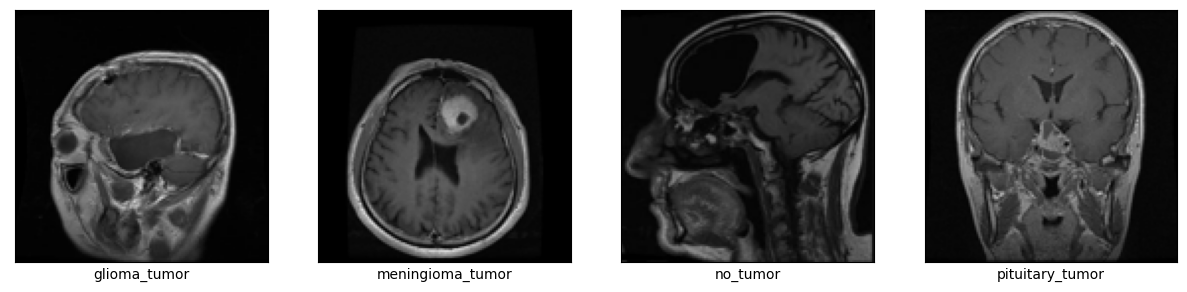

In [59]:
# sample images of what the scans look like
one_image_per_label = [None] * len(labels)

for i in range(len(x_train)):
    label = y_train[i]
    if one_image_per_label[labels.index(label)] is None:
        one_image_per_label[labels.index(label)] = x_train[i]

plt.figure(figsize=(15, 5))
for i in range(len(labels)):
    plt.subplot(1, len(labels), i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(one_image_per_label[i], cmap=plt.cm.binary)
    plt.xlabel(labels[i])
plt.show()

Now, I want to split the data in to training, validation, and testing sets. However, I can set a validation split when fitting the model itself using Keras. So here I will only set a 90% train (to be divided into train and validation later) and a 10% test split. I also augment the data using Keras' ImageDataGenerator using rotations, translations, flipping, and zooming. This allows for the data to be more generalizable and prevent overfitting. I do not include distortions as MRI scans will rarely have extensive distortions. I shuffle the images beforehand to ensure the data is sufficiently randomized, as well as set a random_state (or seed) for reproducibility. 

In [61]:
# shuffle images
x_train, y_train = shuffle(x_train,y_train, random_state=157)

# augmenting the data
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

img_datagen.fit(x_train)

# split data into 90% train, 10% test
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train, test_size=0.1,random_state=157)

In [62]:
# checking dimensions are correct
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2937, 128, 128, 3)
(2937,)
(327, 128, 128, 3)
(327,)


Now, I must normalize the image data using a standard normalizer function to ensure that all features contribute equally to the model training and prevent one feature from dominating due to its larger scale. The function used also checks and accounts for any nan (or N/A, Not a Number) values found. I also perform label encoding to translate the string labels of tumor types into numerical values of 0, 1, 2, & 3. One-hot encoding is then used to convert each category into a binary vector so that the algorithm can effectively process each instance independently.

In [63]:
# standard normalization function - with nan checker / filler in-er
# source: https://github.com/jermwatt/machine_learning_refined
def standard_normalizer(x):    
    # compute the mean and standard deviation of the input
    x_means = np.nanmean(x,axis = 1)[:,np.newaxis]
    x_stds = np.nanstd(x,axis = 1)[:,np.newaxis]   

    # check to make sure that x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind] # Just keep the row index
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # fill in any nan values with means 
    ind = np.argwhere(np.isnan(x) == True)
    for i in ind:
        x[i[0],i[1]] = x_means[i[0]]

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

# normalize
normalizer,inverse_normalizer = standard_normalizer(x_train)
x_train_norm = normalizer(x_train)

normalizer,inverse_normalizer = standard_normalizer(x_test)
x_val_norm = normalizer(x_test)

In [64]:
# using sklearn to convert labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

# to one-hot format
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Training the Model

To train a model, I used a Convolutional Neural Network (CNN), which is typically used for image classification tasks.  It utilizes Conv2D layers for feature extraction, MaxPool2D layers for downsampling, and Dense layers for final classification. Dropout regularization is applied to prevent overfitting, and the model is compiled with the Adam optimizer using categorical crossentropy loss for multi-class classification. During training, the model learns to classify images by adjusting its parameters based on the provided training data, aiming to maximize accuracy on both training and validation sets over multiple epochs. The model is then fit to the training data previously defined with a validation split of 0.2. This brings the dataset ratios to 72% training, 18% validation, and 10% testing. Parameters such as batch size, epochs, filters, and kernel size were intitially set to an example via https://kaggle.com/code/fahadmehfoooz/brain-tumor-detection-keras-pytorch, then adjusted manually by repeating testing to increase accuracy. 

In [81]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same', input_shape=[128, 128, 3]),
          tf.keras.layers.MaxPool2D(pool_size=2),

          tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=2),

          tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=2),

          tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=2),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(4, activation='softmax')
  ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [82]:
history=model.fit(x_train, y_train_one_hot,
                  validation_split=0.15,
                  batch_size=64, 
                  epochs=20,
                  verbose=1,
                  shuffle=True) 

Epoch 1/20
39/39 [==============================] - 32s 772ms/step - loss: 3.5459 - accuracy: 0.3894 - val_loss: 1.0731 - val_accuracy: 0.5306
Epoch 2/20
39/39 [==============================] - 44s 1s/step - loss: 1.0595 - accuracy: 0.5329 - val_loss: 0.8598 - val_accuracy: 0.6531
Epoch 3/20
39/39 [==============================] - 37s 922ms/step - loss: 0.8897 - accuracy: 0.6198 - val_loss: 0.7659 - val_accuracy: 0.7120
Epoch 4/20
39/39 [==============================] - 38s 991ms/step - loss: 0.7958 - accuracy: 0.6679 - val_loss: 0.7478 - val_accuracy: 0.6848
Epoch 5/20
39/39 [==============================] - 46s 1s/step - loss: 0.7171 - accuracy: 0.7127 - val_loss: 0.5975 - val_accuracy: 0.7687
Epoch 6/20
39/39 [==============================] - 49s 1s/step - loss: 0.6550 - accuracy: 0.7248 - val_loss: 0.6329 - val_accuracy: 0.7438
Epoch 7/20
39/39 [==============================] - 44s 1s/step - loss: 0.5854 - accuracy: 0.7596 - val_loss: 0.5371 - val_accuracy: 0.8231
Epoch 8/20


# Model Performance and Testing

I will evaluate the performance of the model by looking at the loss and accuracy functions for both the model and validation sets. If the validation loss increases while the training loss decreases, it suggests overfitting. Conversely, if both losses decrease but remain close, the model is likely well-fitted. Similarly, if the validation accuracy plateaus or decreases while the training accuracy continues to increase, overfitting may be occurring.

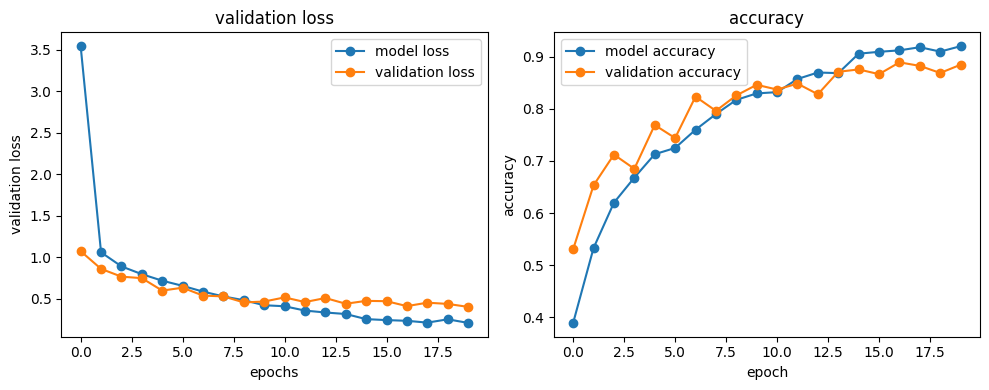

In [83]:
# looking at loss/accuracy graphs!
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# plotting validation loss
axs[0].plot(history.history['loss'], label='model loss', marker='o')
axs[0].plot(history.epoch, history.history['val_loss'], label='validation loss', marker='o')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('validation loss')
axs[0].legend()
axs[0].set_title('validation loss')

# plotting accuracy
axs[1].plot(history.history['accuracy'], label='model accuracy', marker='o')
axs[1].plot(history.history['val_accuracy'], label='validation accuracy', marker='o')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
axs[1].set_title('accuracy')

plt.tight_layout()
plt.show()

As we can see, the model seems to perform very well when compared to the validation data. Loss is sufficiently reduced below 0.5, while accuracy increases to above 0.9. I want to also test the model using the .evaluate function in Keras, a confusion matrix, and an example on our partitioned test data as seen below. 

In [84]:
# testing the model
model.evaluate(x_test, y_test_one_hot)

11/11 [==============================] - 1s 67ms/step - loss: 0.4477 - accuracy: 0.9021


[0.44774070382118225, 0.9021406769752502]

In [93]:
# confusion matrix
predictions = model.predict(x_test)
test_predictions = np.argmax(predictions, axis=1)
test_true = np.argmax(y_test_one_hot, axis=1)
tumor_classification_matrix = confusion_matrix(test_true, test_predictions)
print(tumor_classification_matrix)

11/11 [==============================] - 1s 77ms/step
[[73 10  2  1]
 [ 3 85  4  2]
 [ 2  4 44  2]
 [ 2  0  0 93]]


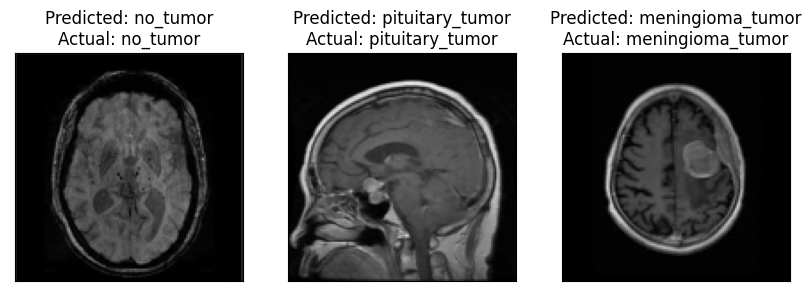

In [95]:
# some examples
plt.figure(figsize=(10, 5))

for i, ind in enumerate([15, 90, 300]):
    # predicted and actual labels
    predicted_label = round(np.argmax(predictions[ind]))
    actual_label = round(np.argmax(y_test_one_hot[ind]))
    
    # plotting
    plt.subplot(1, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[ind], cmap='gray')
    plt.title(f'Predicted: {labels[predicted_label]}\nActual: {labels[actual_label]}')
    
plt.show()

We can see from the output that the accuracy and loss of our model on the test data is 90.21% and 44.77%, respectively. 

A confusion matrix is computed using the test predictions and true labels. This matrix provides a summary of the model's performance by comparing predicted labels with actual labels. Each row represents the actual class, while each column represents the predicted class. The diagonal represents the number of correct predictions made, while everything outside of the diagonal is the incorrect predictions. We can see here that the number of misclassifications is 28, and thus the misclassification rate is 8.56%. Additionally, it is found that the highest percentage of misclassifications occur in identifying a tumor as a meningioma when it it actually a glioma. The lowest number of misclassifications come from the pituitary tumor. This aligns with what we know (as previously mentioned) as gliomas do have very irregular borders and might be difficult to distinguish. However, it is interesting that pituitary tumors are misclassified the least often, when meningiomas are known to be very distinguishable within MRI scans. This could be due to a number of factors, however it is notable that the majority of images in the pituitary_tumor label (under both training and testing) are displayed with the saggital (side) view as opposed the coronal (back) or axial (top) view, which may include more structures or folds in the brain that could pose issues in distinguishing the tumor. A larger training dataset or higher computational power of a computer to increase the complexity of the neural network may aid in the generalizability of this model. 

Lastly, the predicted label and actual label are extracted from the model's predictions and one-hot encoded true labels. The example image from the test data is displayed along with the predicted and actual labels, where we can see that the model has predicted the examples shown correctly.

# References:
Brain Tumor Detection- Keras/Pytorch. (n.d.). Retrieved April 22, 2024, from https://kaggle.com/code/fahadmehfoooz/brain-tumor-detection-keras-pytorch

Brain Tumor Classification (MRI). (n.d.). Retrieved April 22, 2024, from https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data

MobileNet Brain Tumor MRI Classification. (n.d.). Retrieved April 22, 2024, from https://kaggle.com/code/atharvamuley25/mobilenet-brain-tumor-mri-classification

Watt, J. (2024). Jermwatt/machine_learning_refined [Python]. https://github.com/jermwatt/machine_learning_refined (Original work published 2016)
